<a href="https://colab.research.google.com/github/sidharth-red/MCMC/blob/main/PTMCMC_quadratic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
!pip install -U corner
import corner
!pip install -U emcee
import emcee
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_probability as tfp

sns.reset_defaults()
sns.set_context(context='talk',font_scale=0.7)
plt.rcParams['image.cmap'] = 'viridis'

%matplotlib inline

tfd = tfp.distributions
tfb = tfp.bijectors
from tensorflow_probability.python.mcmc import kernel as kernel_base

def nparr(array_):
  return np.array([float(x) for x in array_])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 1.4 MB/s eta 0:00:00


In [2]:
SEED = 42229
num_features = 1 # number of dimensions of indepdendent vars
num_parameters = 3 # number of parameters in the model
num_data_points = 1000
std_err = 5.
true_theta = nparr([-10, 20, 30])
x_min, x_max = -5., 5.
num_burn_in_steps = 5000
num_posterior_samples = 10000
# num_mcmc_runs = 8
initial_state = np.zeros(num_parameters)

num_temperatures = 10
inverse_temperatures = 0.6**tf.range(num_temperatures, dtype=np.float64)
# step_size = 2 / tf.reshape(tf.repeat(inverse_temperatures, repeats=num_parameters), (num_temperatures, num_parameters))
step_size = tf.reshape(tf.repeat(np.float64(.1), num_temperatures * num_parameters), (num_temperatures, num_parameters))
parameter_labels = ['a', 'b', 'c']

assert len(parameter_labels) == num_parameters
assert num_posterior_samples > num_burn_in_steps
assert initial_state.shape == (num_parameters,)
assert true_theta.shape == (num_parameters,)
assert x_min < x_max

(1, 1000)


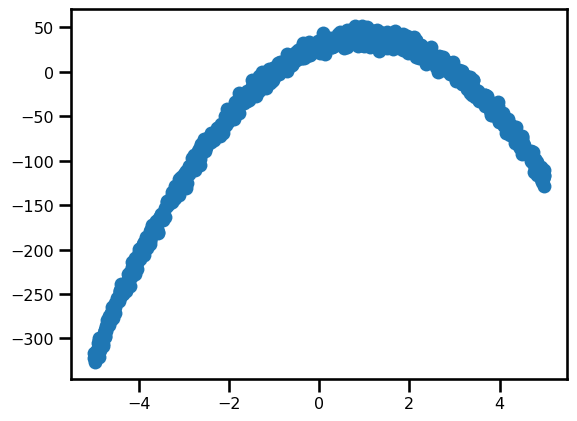

In [3]:
rng = np.random.default_rng(SEED)
# Generate some data
def gen_points(x, theta):
    # Split theta into m and b
    a, b, c = tf.split(theta, num_or_size_splits=3, axis=-1)

    # # Reshape m and b to ensure they broadcast correctly
    # a = tf.reshape(a, (-1,) + (1,) * (len(x.shape) - 1))
    # b = tf.reshape(b, (-1,) + (1,) * (len(x.shape) - 1))
    # c = tf.reshape(c, (-1,) + (1,) * (len(x.shape) - 1))

    # Compute the output
    return (a * x**2) + (b*x) +c

  # x = tf.pad(x, [[1, 0], [0, 0]], constant_values=1)
  # # print(x)
  # linop = tf.linalg.LinearOperatorFullMatrix(w[..., np.newaxis])
  # # print(linop.adjoint().shape)
  # result = linop.matmul(x, adjoint=True)

  # return result[0, :]
xs = tf.convert_to_tensor(rng.uniform(x_min, x_max, [num_features, num_data_points]))
ys = gen_points(xs, true_theta) + rng.normal(0., std_err, size=num_data_points)
print(ys.shape)

# Visualize the data set
plt.scatter(xs, ys, s=100, linewidths=0)
xs_grid = np.linspace(x_min, x_max, 100)
ys_grid = gen_points(xs_grid, true_theta)
plt.plot(xs_grid, ys_grid)
plt.show()

In [4]:
# Define the joint_log_prob function, and our unnormalized posterior.
@tf.function
def lnprior(theta):
  # print(theta[0])
  # y =
  # if theta[0] > 0.0:
  #   return np.float64(-np.inf)
  return np.float64(0.0)
  # return tfd.MultivariateNormalDiag(
  #   loc=np.zeros(num_parameters),
  #   scale_diag=np.ones(num_parameters)).log_prob(theta)
  # assuming a perfectly uniform prior with absolutely no restrictions on theta,
  # we will always return 0.0. This is a similar convention to emcee.

# Create our unnormalized target density by currying x and y from the joint.
def unnormalized_posterior(theta):
  likelihoods = tfd.Normal(gen_points(xs, theta), std_err) #tfd.Normal(f(xs, theta), std_err)
                                                           #creates a normal distribution for
                                                           #each predicted value with a mean of
                                                           #gen_points(xs, theta) and a standard deviation
                                                           #of std_err.'''
  return (lnprior(theta) +
          tf.reduce_sum(likelihoods.log_prob(ys)))

In [13]:
# Create an HMC TransitionKernel
# Create an HMC TransitionKernel

# def make_kernel_fn(target_log_prob_fn):
#   return tfp.mcmc.HamiltonianMonteCarlo(
#     target_log_prob_fn=target_log_prob_fn,
#     step_size=step_size,
#     num_leapfrog_steps=2)

def make_kernel_fn(target_log_prob_fn):
  kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_fn,
    step_size=step_size,
    num_leapfrog_steps=2)
  return tfp.mcmc.SimpleStepSizeAdaptation(
        kernel,
        num_adaptation_steps=int(.8 * num_burn_in_steps),
        target_accept_prob=np.float64(.3))

# def make_kernel_fn(target_log_prob_fn):
#   return tfp.mcmc.RandomWalkMetropolis(target_log_prob_fn=target_log_prob_fn)

# def make_kernel_fn(target_log_prob_fn):
#   return tfp.mcmc.MetropolisAdjustedLangevinAlgorithm()
#       target_log_prob_fn=target_log_prob_fn,
#       step_size=step_size)

In [14]:
# We wrap sample_chain in tf.function, telling TF to precompile a reusable
# computation graph, which will dramatically improve performance.
@tf.function
def run_chain(kernel, initial_state, num_posterior_samples=num_posterior_samples, num_burnin_steps=num_burn_in_steps):
    return tfp.mcmc.sample_chain(
        num_results=num_posterior_samples,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        kernel=kernel,
        trace_fn=lambda current_state, kernel_results: kernel_results)


In [15]:
remc = tfp.mcmc.ReplicaExchangeMC(
    target_log_prob_fn=unnormalized_posterior,
    inverse_temperatures=inverse_temperatures,
    make_kernel_fn=make_kernel_fn)

(10000, 3)
[[-10.21994251  19.94098742  25.89820702]
 [ -9.95695834  19.88021786  29.07106554]
 [ -9.25258808  19.96105553  25.98838216]
 ...
 [ -9.85018203  19.94581224  27.93829633]
 [ -9.94880883  20.02174572  29.18695017]
 [ -9.85930342  19.91735031  27.93483809]]


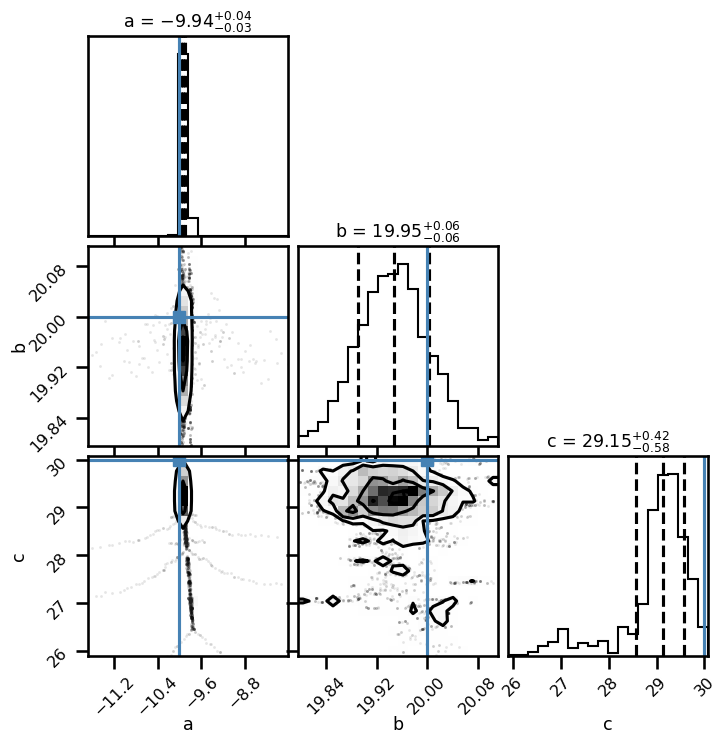

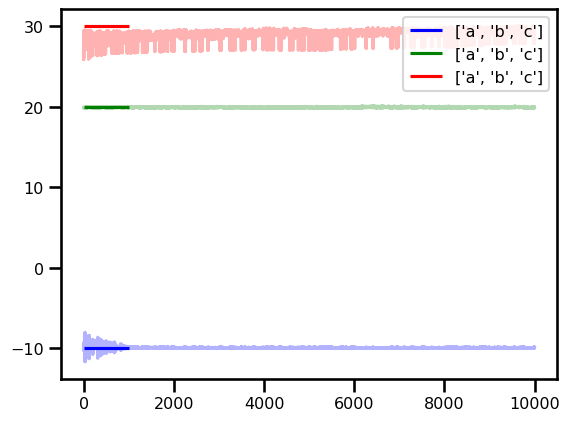

In [19]:
samples, kernel_results = run_chain(remc, initial_state)
print(samples.numpy().shape)
print(samples.numpy())
# print("Acceptance rate:", kernel_results.is_accepted.numpy().mean())
fig = corner.corner(samples.numpy(),
                    show_titles=True,
                    labels=parameter_labels,
                    plot_datapoints=True,
                    quantiles=[0.16, 0.5, 0.84],
                    truths=true_theta)
plt.show()

colors = ['b', 'g', 'r']
for i in range(3):
  plt.plot(samples[:, i], c=colors[i], alpha=.3)
  plt.hlines(true_theta[i], 0, 1000, zorder=4, color=colors[i], label=parameter_labels)
plt.legend(loc='upper right')
plt.show()
# print("Acceptance rate:", kernel_results.is_accepted.numpy().mean())

In [ ]:
# j = 0.1
# for i in range(2, 10):
#   while j <= 0.5:
#     num_temperatures = i
#     inverse_temperatures = np.float64(j)**tf.range(num_temperatures, dtype=np.float64)
#     step_size = 2 / tf.reshape(tf.repeat(inverse_temperatures, repeats=num_parameters), (num_temperatures, num_parameters))

#     remc = tfp.mcmc.ReplicaExchangeMC(
#       target_log_prob_fn=unnormalized_posterior,
#       inverse_temperatures=inverse_temperatures,
#       make_kernel_fn=make_kernel_fn)

#     samples, kernel_results = run_chain(remc, initial_state)
#     print("num_temperatures = ", num_temperatures)
#     print(f"j = {j}")
#     # print("Acceptance rate:", kernel_results.is_accepted.numpy().mean())
#     fig = corner.corner(samples.numpy(),show_titles=True,labels=['m', 'b'],plot_datapoints=True,quantiles=[0.16, 0.5, 0.84], truths=true_theta)
#     plt.show()
#     j += 0.1